## Imports

In [129]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import eurostat
import os

%matplotlib inline

In [130]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

In [131]:
# Show more columns without truncation
pd.set_option('display.max_columns', None)

# Show more rows
pd.set_option('display.max_rows', None)

# Increase column width
pd.set_option('display.max_colwidth', 100)

## Research Questions

#### 1. How does GDP per capita relate to tertiary education attainment?

#### 2. Is there a correlation between GDP per capita and greenhouse gas emissions?

#### 3. How does tertiary education attainment correlate with unemployment rate?

## Analysis

### Utils

In [132]:
agg_dict_yearly = {
    'gdp': 'first',                         
    'inflation_rate_anually': 'first',      
    'education_attainment': 'first',        
    'gdp_per_capita': 'first',
    'gdp_growth_rate': 'first',
    'price_index': 'last',                  # take last month of year
    'energy_prices': 'mean',                # average if multiple months
    'gas_emissions': 'first',
    'household_income_q1': 'first',
    'household_income_q2': 'first',
    'household_income_q3': 'first',
    'net_migration': 'first',
    'total_population': 'first',
    'net_population_growth': 'first',
    'growth_rate': 'first',
    'births': 'first',
    'deaths': 'first',
    'inflation_rate_monthly_y': lambda x: x.mean().round(1) if len(x) == 12 else np.nan,
    'total_unemployment_rate': 'mean',      # average monthly unemployment
    'adult_unemployment_rate': 'mean',
    'youth_unemployment_rate': 'mean'
}

drop_list_yearly = [
    'gdp_quarterly',
    'inflation_rate_monthly_m',
    'inflation_rate_anually'
]

rename_dict_cols = {
    'inflation_rate_monthly_y': 'inflation_rate'
}

In [133]:
def aggregate_data_on_frequency(raw_df, frequency='Y'):
    df = raw_df.copy()
    df['TIME_PERIOD'] = pd.to_datetime(df['TIME_PERIOD'], errors='coerce')
    
    aggregate_df = pd.DataFrame()
    
    if frequency == 'Y':
        df['year'] = df['TIME_PERIOD'].dt.year
        aggregate_df = df.groupby('year').agg(agg_dict_yearly).reset_index()
        aggregate_df['TIME_PERIOD'] = pd.to_datetime(aggregate_df['year'].astype(str))
        aggregate_df = aggregate_df.drop(columns='year')
    
    aggregate_df['household_income'] = aggregate_df[[
        'household_income_q1',
        'household_income_q2',
        'household_income_q3']].mean(axis=1)
        
    aggregate_df = aggregate_df.drop(columns=[col for col in drop_list_yearly if col in aggregate_df.columns])
    
    aggregate_df = aggregate_df.rename(
        columns={old: new for old, new in rename_dict_cols.items() if old in aggregate_df.columns}
    )
    cols = list(aggregate_df.columns)
    cols.insert(0, cols.pop(cols.index('TIME_PERIOD')))
    aggregate_df = aggregate_df.loc[:, cols]
    
    return aggregate_df

In [134]:
def impute_missing_data(raw_df):
    df = raw_df.copy()
    df['TIME_PERIOD'] = pd.to_datetime(df['TIME_PERIOD'], errors='coerce')
    df = df.set_index('TIME_PERIOD')
    
    numeric_cols = df.select_dtypes(include='number').columns
    
    for col in numeric_cols:
        df[col] = df[col].interpolate(method='linear').ffill().bfill()
    
    return df

In [135]:
def plot_dataframe(df, n_cols=4, plot='hist', comparison='TIME_PERIOD'):
    num_cols = df.select_dtypes(include='number').columns
    n_rows = int(len(num_cols) / n_cols) + 1

    plots = ['hist', 'box', 'line', 'scatter']
    
    if comparison not in df.columns:
        return print("Unknown feature column to compare with.")
    
    if plot not in plots:
        return print("Unknown plot option.")
    
    plt.figure(figsize=(20, 15))
    
    for i, col in enumerate(num_cols, 1):
        plt.subplot(n_rows, n_cols, i)
        
        if plot == 'hist':
            sns.histplot(data=df, x=col, kde=True)
        elif plot == 'box':
            sns.boxplot(data=df, x=col)
        elif plot == 'line':
            sns.lineplot(data=df, x=comparison, y=col)
        elif plot == 'scatter':
            sns.scatterplot(data=df, x=comparison, y=col)
        
        plt.title(col, fontsize=10)
        plt.tight_layout()

    plt.show()
    
    return None

### Dataset Analysis

In [136]:
FILE_PATH = "eurostat_data/sweden_eurostat_data.csv"
CLEAN_DF_PATH = "clean_data"

In [137]:
df = pd.read_csv(FILE_PATH)

df.tail()

,TIME_PERIOD,gdp_quarterly,gdp,inflation_rate_anually,education_attainment,gdp_per_capita,gdp_growth_rate,price_index,energy_prices,inflation_rate_monthly_m,inflation_rate_monthly_y,gas_emissions,household_income_q1,household_income_q2,household_income_q3,net_migration,total_population,net_population_growth,growth_rate,births,deaths,total_unemployment_rate,adult_unemployment_rate,youth_unemployment_rate
304,2025-05-01,NaN,NaN,NaN,NaN,NaN,NaN,131.96,NaN,0.3,2.3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.1,6.9,25.0
305,2025-06-01,NaN,NaN,NaN,NaN,NaN,NaN,132.71,NaN,0.6,2.9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.3,6.2,23.9
306,2025-07-01,NaN,NaN,NaN,NaN,NaN,NaN,133.12,NaN,0.3,3.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.9,6.7,24.6
307,2025-08-01,NaN,NaN,NaN,NaN,NaN,NaN,132.69,NaN,-0.3,3.4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.8,6.6,24.4
308,2025-09-01,NaN,NaN,NaN,NaN,NaN,NaN,132.90,NaN,0.2,3.2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.7,6.7,23.6


In [138]:
df.info() # Correct data types

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 309 entries, 0 to 308
Data columns (total 24 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   TIME_PERIOD               309 non-null    object 
 1   gdp_quarterly             102 non-null    float64
 2   gdp                       25 non-null     float64
 3   inflation_rate_anually    12 non-null     float64
 4   education_attainment      12 non-null     float64
 5   gdp_per_capita            25 non-null     float64
 6   gdp_growth_rate           12 non-null     float64
 7   price_index               309 non-null    float64
 8   energy_prices             37 non-null     float64
 9   inflation_rate_monthly_m  309 non-null    float64
 10  inflation_rate_monthly_y  309 non-null    float64
 11  gas_emissions             24 non-null     float64
 12  household_income_q1       21 non-null     float64
 13  household_income_q2       21 non-null     float64
 14  household_

In [139]:
# df = impute_missing_data(df)

# df.head(200)

In [140]:
df.describe() # Consistent data 

,gdp_quarterly,gdp,inflation_rate_anually,education_attainment,gdp_per_capita,gdp_growth_rate,price_index,energy_prices,inflation_rate_monthly_m,inflation_rate_monthly_y,gas_emissions,household_income_q1,household_income_q2,household_income_q3,net_migration,total_population,net_population_growth,growth_rate,births,deaths,total_unemployment_rate,adult_unemployment_rate,youth_unemployment_rate
count,102.000000,25.000000,12.000000,12.000000,25.000000,12.000000,309.000000,37.000000,309.000000,309.000000,24.000000,21.000000,21.000000,21.000000,25.000000,2.500000e+01,25.00000,25.000000,25.00000,25.000000,309.000000,309.000000,309.000000
mean,97998.500000,390477.644000,2.283333,41.153125,40362.000000,1.783333,99.768350,0.168519,0.166990,2.027184,41.911029,16615.285714,23089.619048,30451.333333,53354.000000,9.626437e+06,69051.36000,7.124000,107652.76000,91955.400000,7.416181,5.645631,20.194175
std,13442.183809,53771.776196,2.374805,4.184533,3176.974452,1.876570,13.790871,0.020821,0.483236,1.821687,6.969710,2111.023239,3412.198038,4953.777027,25221.262751,5.898073e+05,32946.55978,3.260787,8225.49297,2084.665501,1.001069,0.712656,3.752242
min,73892.100000,303735.800000,0.200000,34.712500,34240.000000,-1.900000,78.830000,0.135145,-1.800000,-0.300000,30.435070,13211.000000,17329.000000,22286.000000,24386.000000,8.872109e+06,21366.00000,2.400000,90441.00000,88766.000000,4.900000,3.800000,9.600000
25%,88091.375000,352131.300000,0.700000,38.237500,38060.000000,1.025000,88.410000,0.154708,-0.100000,1.100000,36.785877,14740.000000,20217.000000,26045.000000,28820.000000,9.080505e+06,36003.00000,4.000000,100928.00000,90532.000000,6.600000,5.100000,17.800000
50%,96322.000000,384163.200000,1.800000,41.062500,40590.000000,1.850000,98.880000,0.167951,0.200000,1.600000,42.337325,17379.000000,24700.000000,32805.000000,50769.000000,9.519374e+06,69670.00000,7.200000,111770.00000,91710.000000,7.500000,5.700000,20.600000
75%,109955.450000,437536.900000,2.175000,44.243750,42750.000000,2.375000,106.580000,0.175551,0.500000,2.300000,48.081680,18132.000000,25498.000000,33957.000000,65780.000000,1.017521e+07,88971.00000,9.300000,114523.00000,92961.000000,8.100000,6.100000,22.900000
max,119066.000000,471972.800000,8.100000,47.562500,44560.000000,5.200000,133.120000,0.219686,2.100000,10.800000,51.857060,19366.000000,27250.000000,36598.000000,117693.000000,1.056971e+07,144136.00000,14.500000,117425.00000,98124.000000,9.600000,7.700000,29.900000


In [141]:
# Data is missing due to difference in frequency (M vs Q vs Y) - (Missing Not at Random)

df.isnull().sum()

TIME_PERIOD                   0
gdp_quarterly               207
gdp                         284
inflation_rate_anually      297
education_attainment        297
gdp_per_capita              284
gdp_growth_rate             297
price_index                   0
energy_prices               272
inflation_rate_monthly_m      0
inflation_rate_monthly_y      0
gas_emissions               285
household_income_q1         288
household_income_q2         288
household_income_q3         288
net_migration               284
total_population            284
net_population_growth       284
growth_rate                 284
births                      284
deaths                      284
total_unemployment_rate       0
adult_unemployment_rate       0
youth_unemployment_rate       0
dtype: int64

In [142]:
df['gdp_growth_rate'] = (df['gdp'].pct_change() * 100).round(1)
df.loc[df['gdp'].isna(), 'gdp_growth_rate'] = np.nan

/var/folders/ds/h92m23qx1rg8ky9r047dvv280000gp/T/ipykernel_13791/1429878751.py:1: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  df['gdp_growth_rate'] = (df['gdp'].pct_change() * 100).round(1)


In [143]:
aggregate_df = aggregate_data_on_frequency(df)

aggregate_df.tail()

,TIME_PERIOD,gdp,education_attainment,gdp_per_capita,gdp_growth_rate,price_index,energy_prices,gas_emissions,household_income_q1,household_income_q2,household_income_q3,net_migration,total_population,net_population_growth,growth_rate,births,deaths,inflation_rate,total_unemployment_rate,adult_unemployment_rate,youth_unemployment_rate,household_income
21,2021-01-01,463274.9,43.7375,44480.0,5.2,113.71,0.186177,33.28990,18132.0,25498.0,33957.0,50726.0,10415811.0,73031.0,7.0,114263.0,91958.0,2.6,8.883333,6.891667,24.683333,25862.333333
22,2022-01-01,469091.0,45.7625,44560.0,1.3,126.04,0.198118,30.84396,18933.0,26738.0,36076.0,59233.0,10486941.0,69230.0,6.6,104734.0,94737.0,8.0,7.483333,5.600000,21.566667,27249.000000
23,2023-01-01,468133.8,46.7750,44170.0,-0.2,128.38,0.199851,30.43507,19355.0,27250.0,36432.0,24485.0,10536632.0,30151.0,2.9,100051.0,94385.0,6.0,7.675000,5.766667,21.766667,27679.000000
24,2024-01-01,471972.8,47.5625,44400.0,0.8,130.46,0.195697,NaN,19366.0,26915.0,36598.0,28820.0,10569709.0,36003.0,3.4,98451.0,91268.0,2.0,8.375000,6.258333,24.016667,27626.333333
25,2025-01-01,NaN,NaN,NaN,NaN,132.90,0.209401,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.755556,6.688889,23.977778,NaN


### Outliers

In [144]:
numeric_cols = aggregate_df.select_dtypes(include='number').columns
outliers_dict = {}

for col in numeric_cols:
    Q1 = aggregate_df[col].quantile(0.25)
    Q3 = aggregate_df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR

    outliers = aggregate_df[(aggregate_df[col] < lower) | (aggregate_df[col] > upper)][col]
    if not outliers.empty:
        outliers_dict[col] = outliers

outliers_df = pd.DataFrame.from_dict(outliers_dict).reset_index(names='index_row')

outliers_df

,index_row,gdp_growth_rate,deaths,inflation_rate,youth_unemployment_rate
0,0,NaN,NaN,NaN,10.508333
1,9,-4.3,NaN,NaN,NaN
2,20,NaN,98124.0,NaN,NaN
3,22,NaN,NaN,8.0,NaN
4,23,NaN,NaN,6.0,NaN


### Visualizations

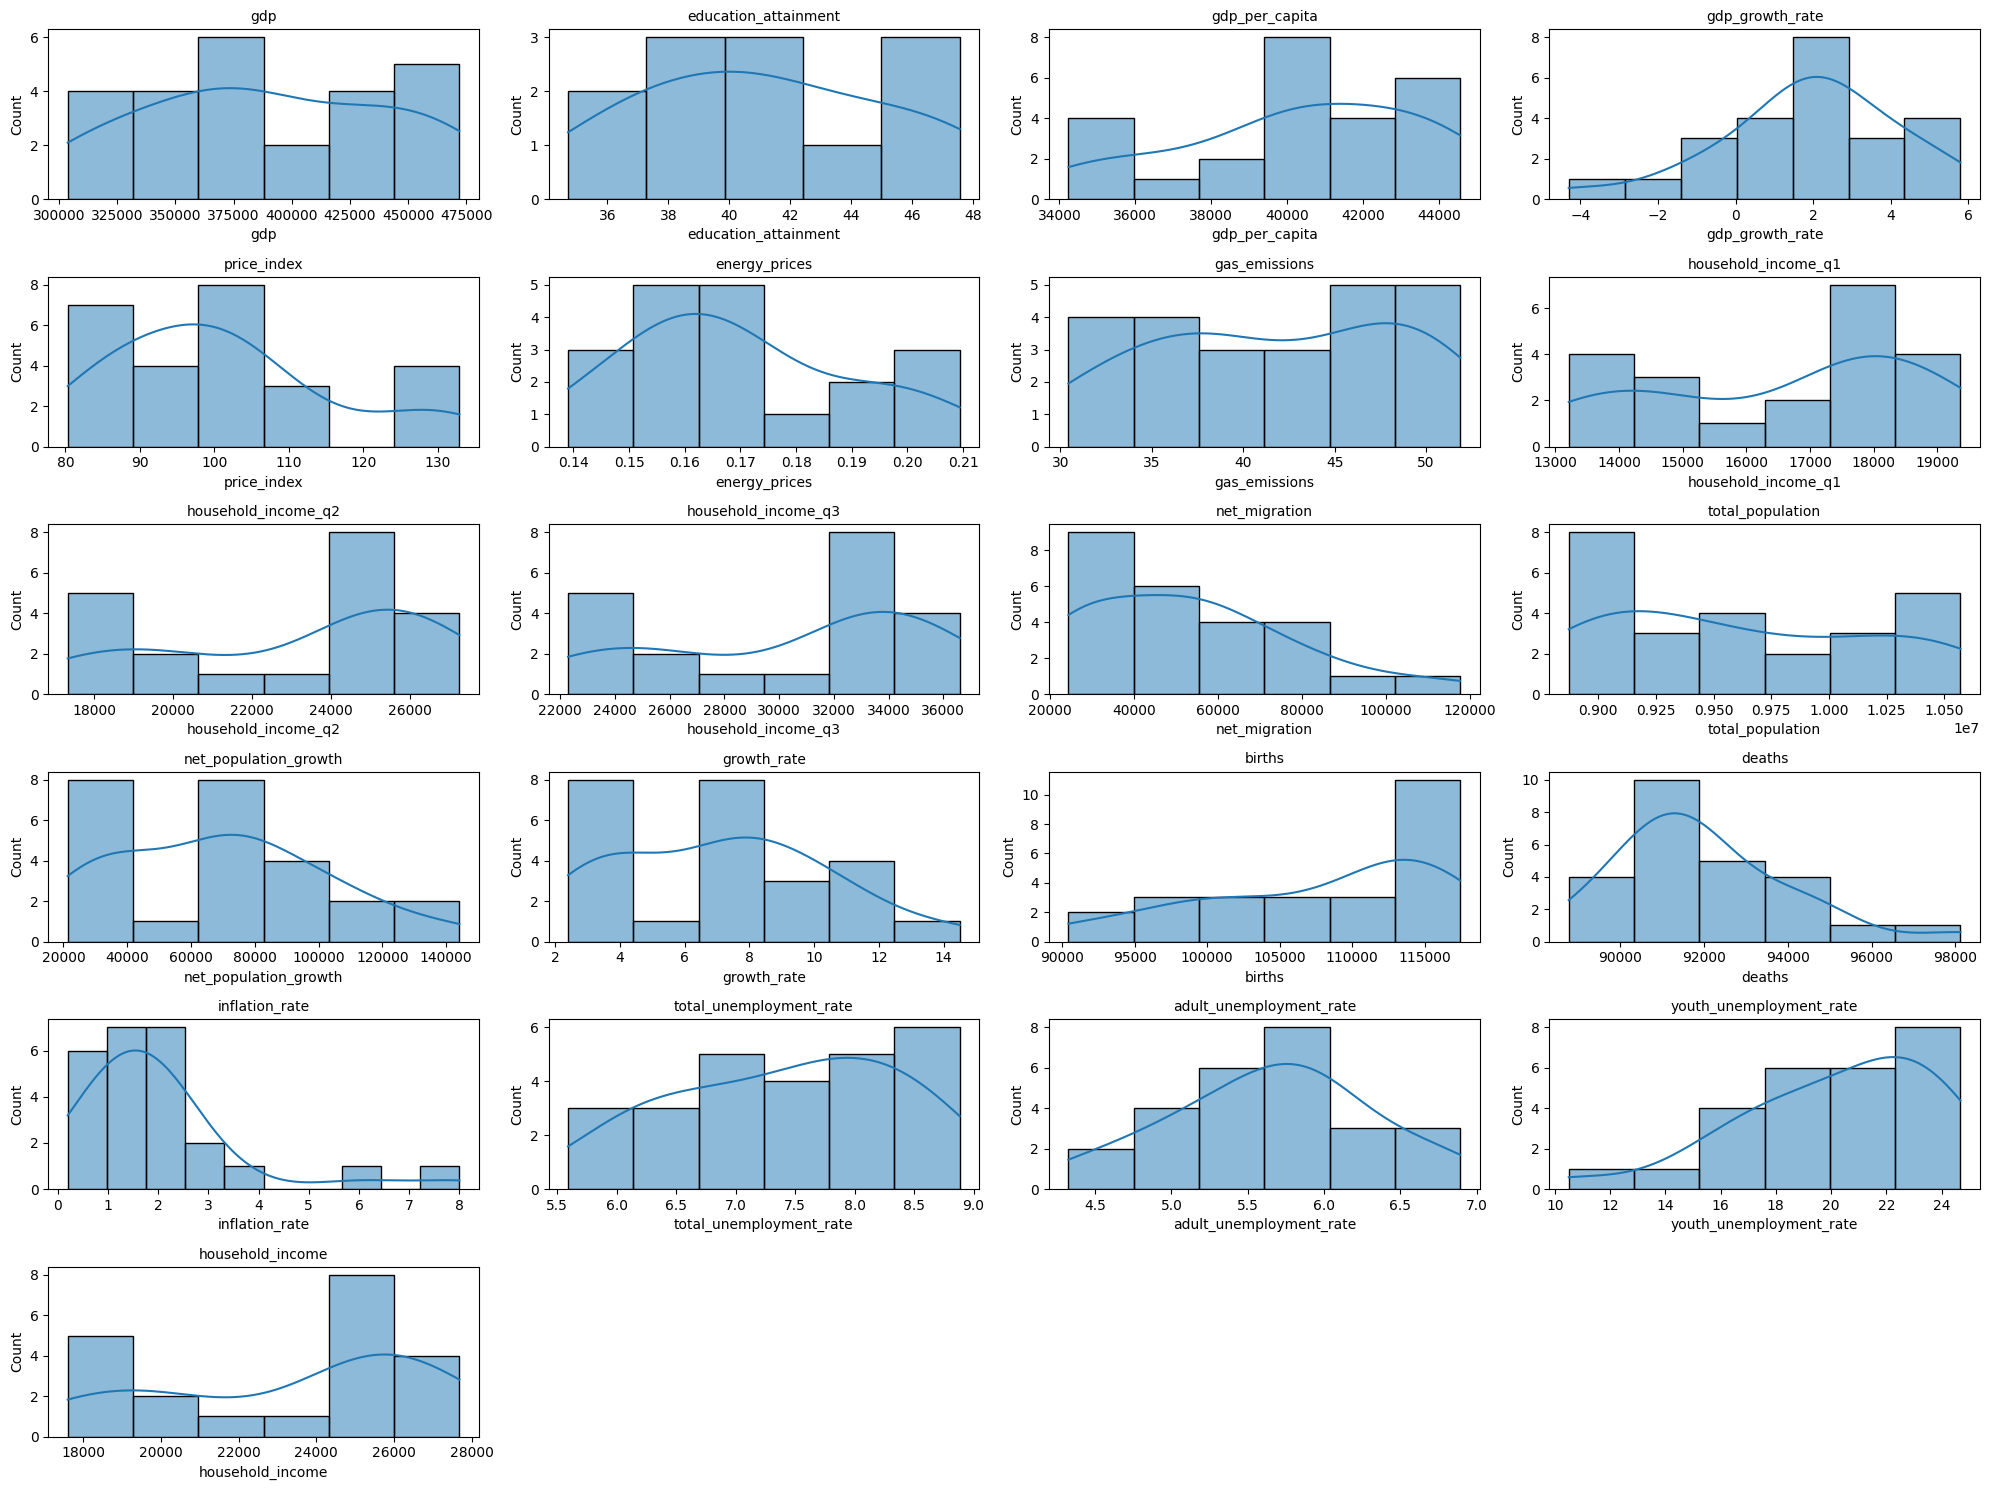

In [146]:
plot_dataframe(df=aggregate_df, plot='hist')

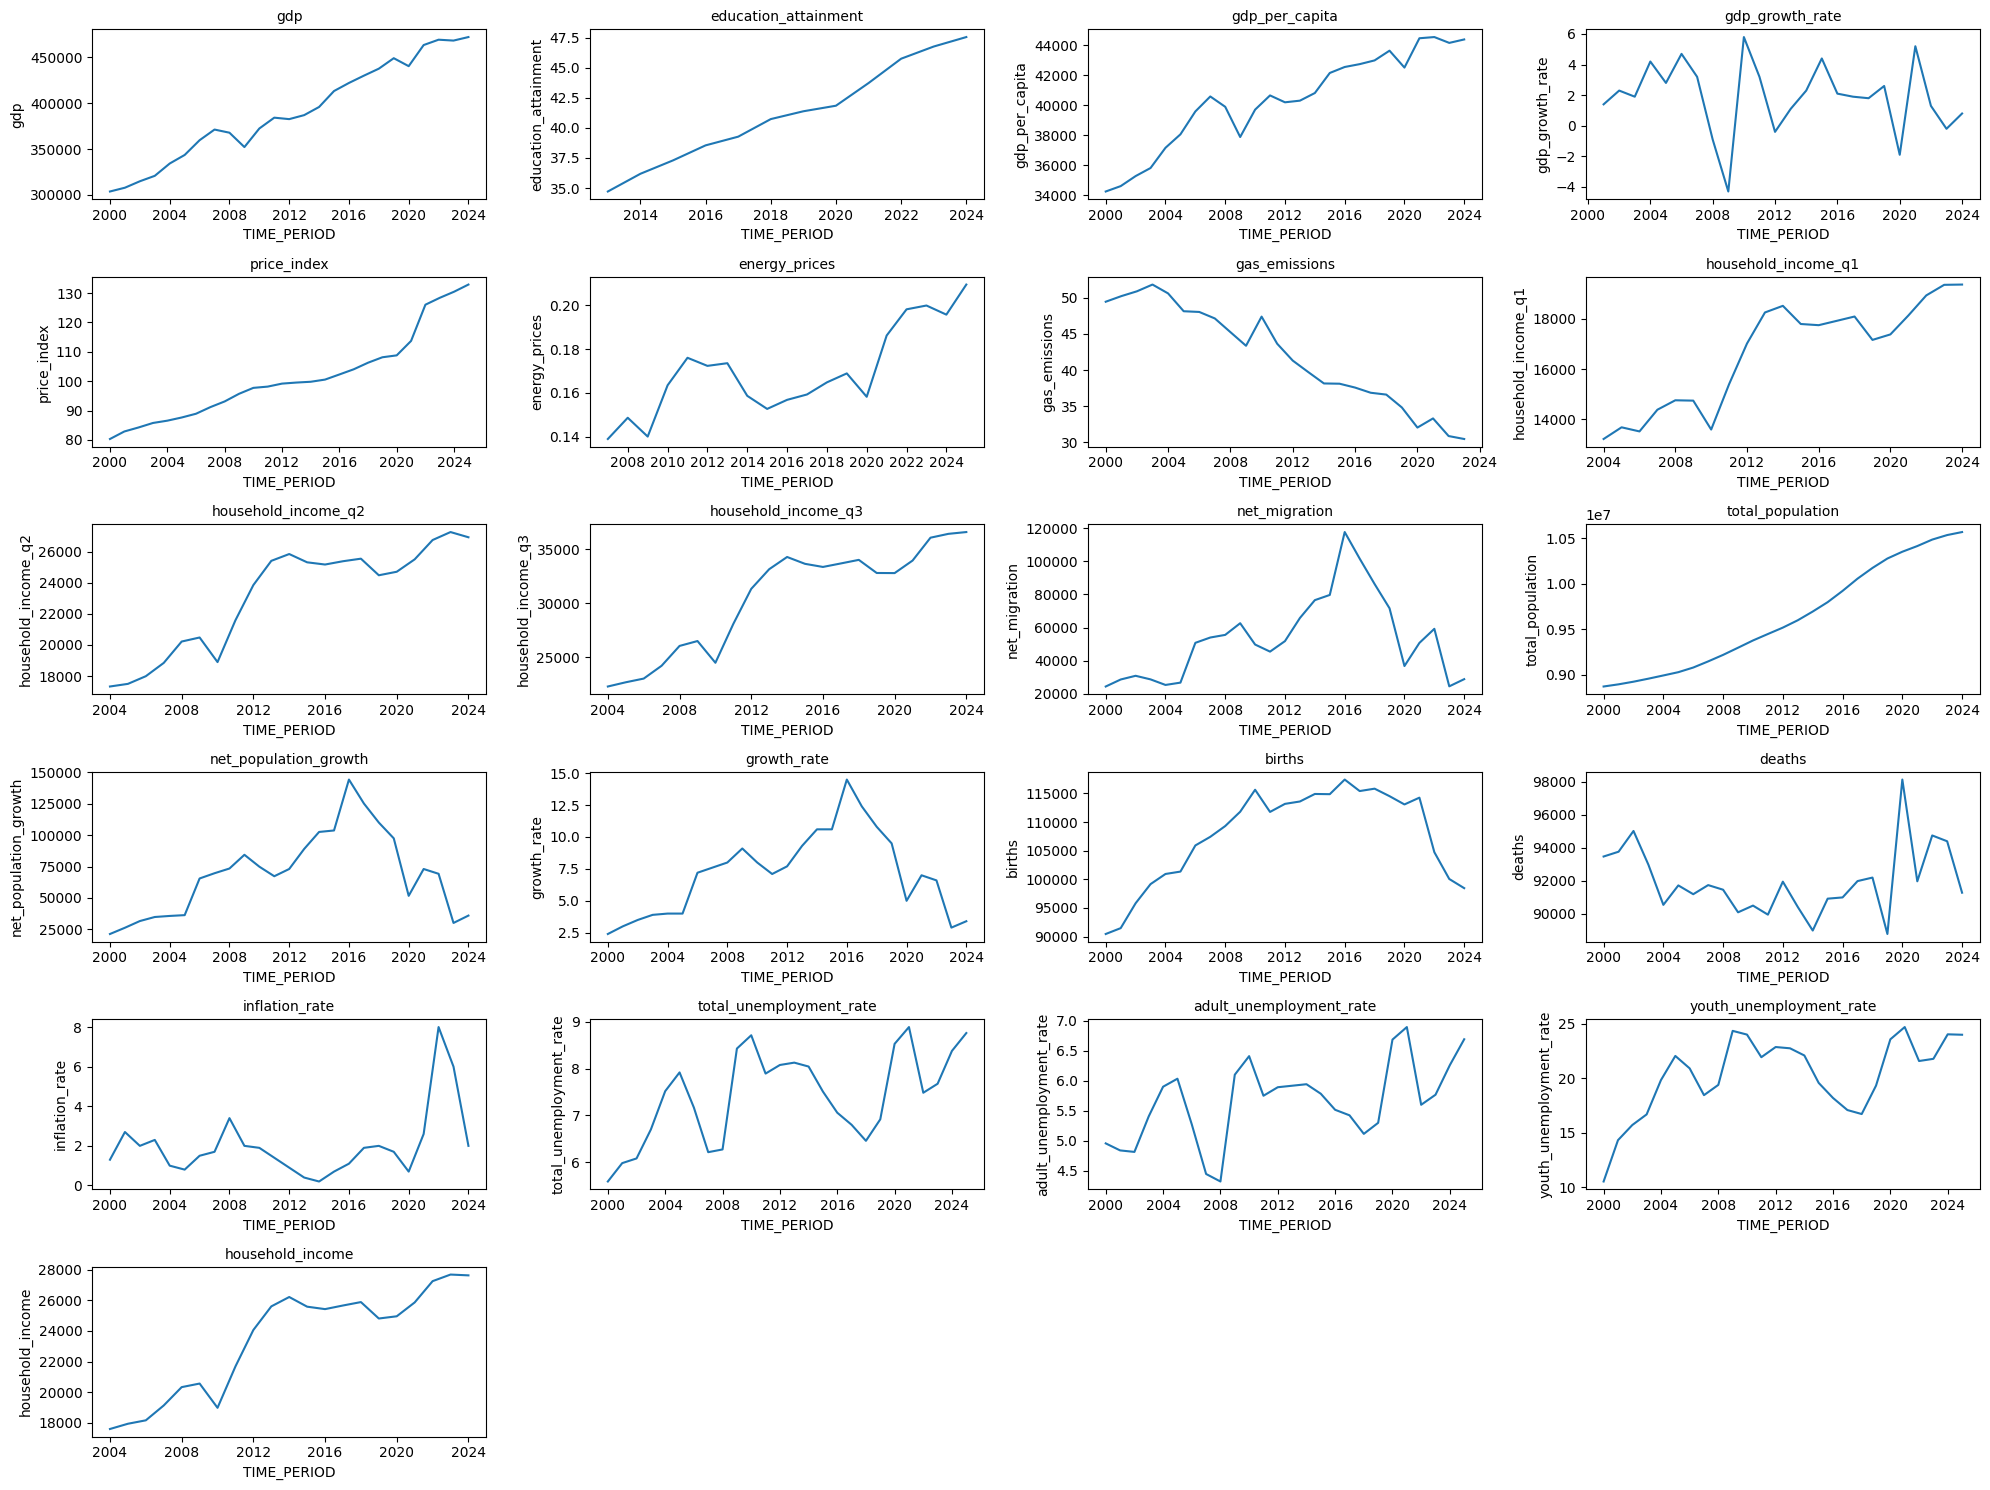

In [147]:
plot_dataframe(df=aggregate_df, plot='line')

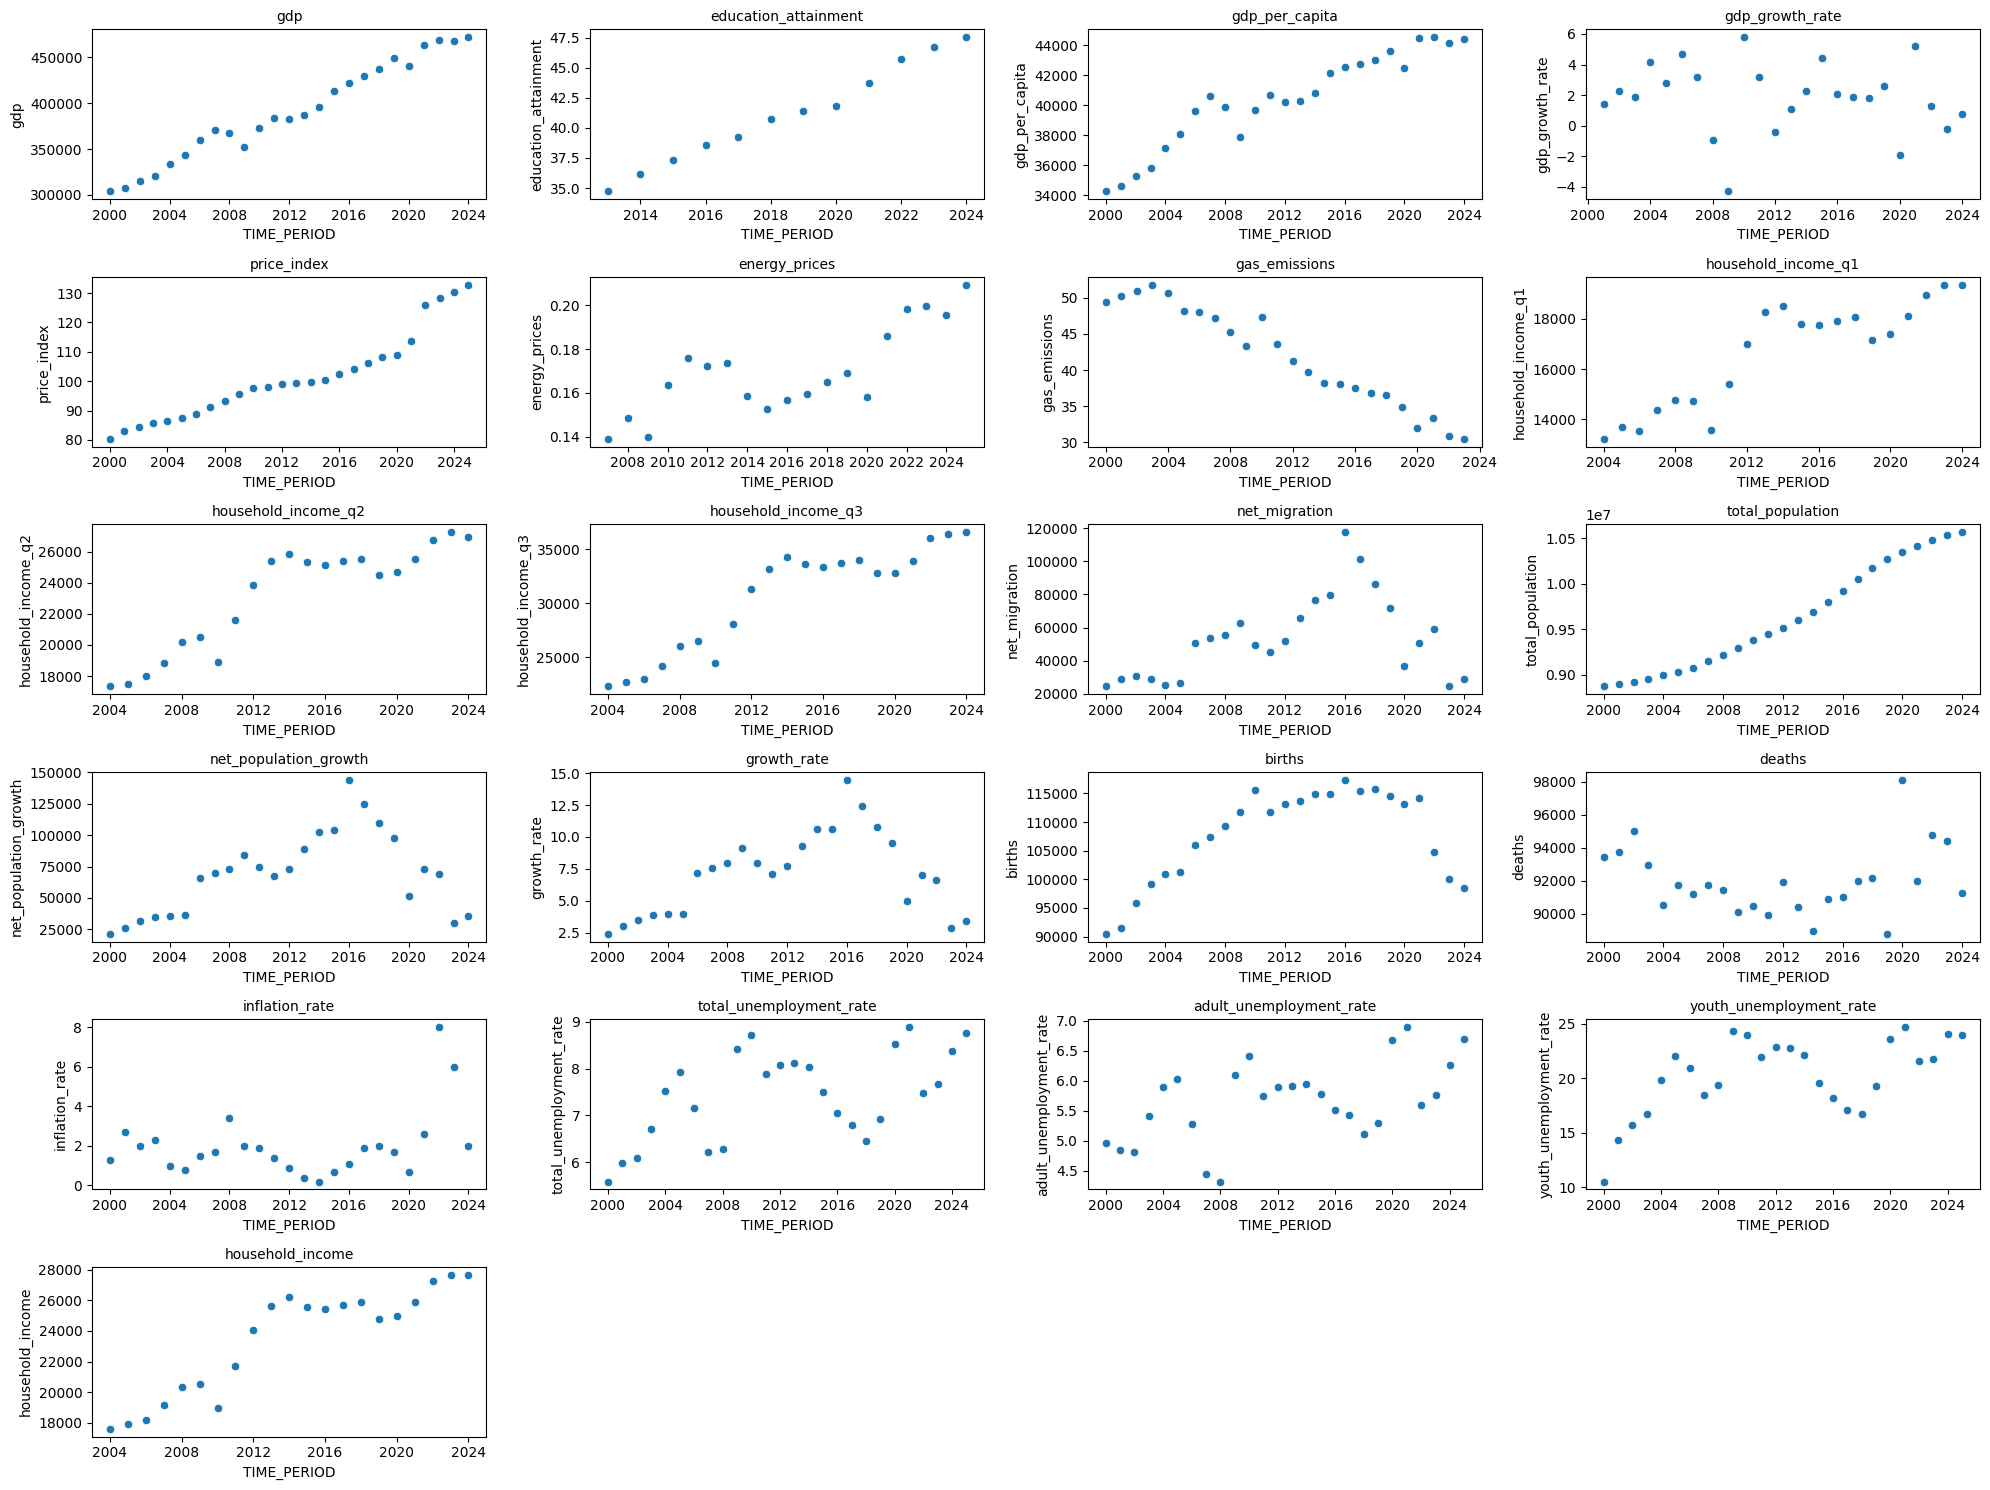

In [148]:
plot_dataframe(df=aggregate_df, plot='scatter')

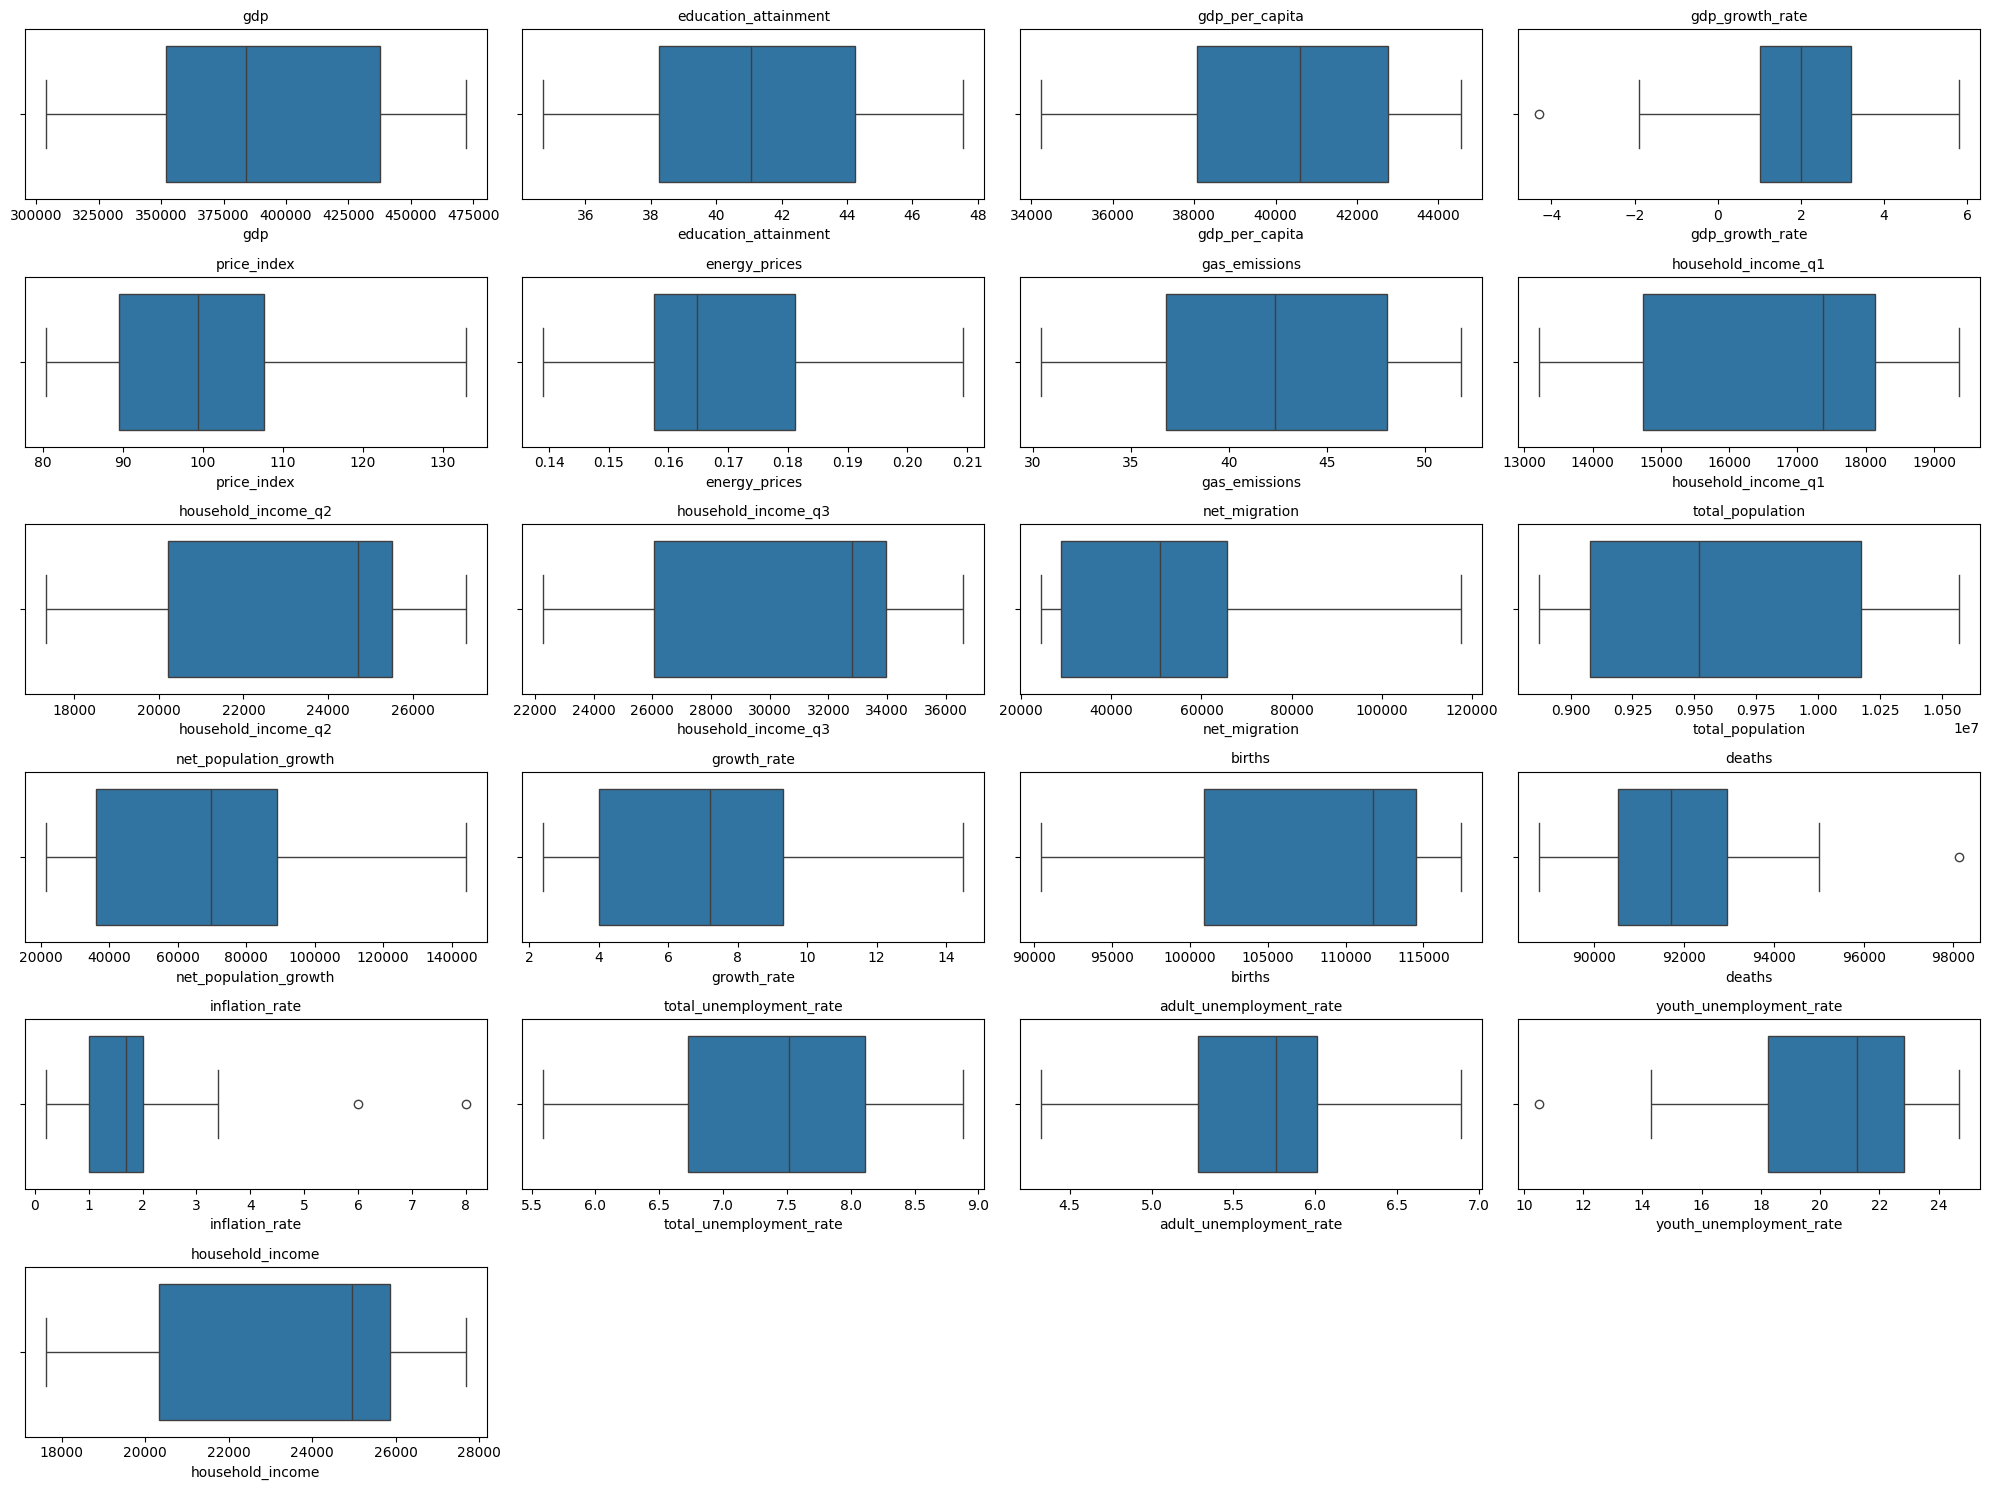

In [149]:
plot_dataframe(df=aggregate_df, plot='box')

#### Bivariate Data

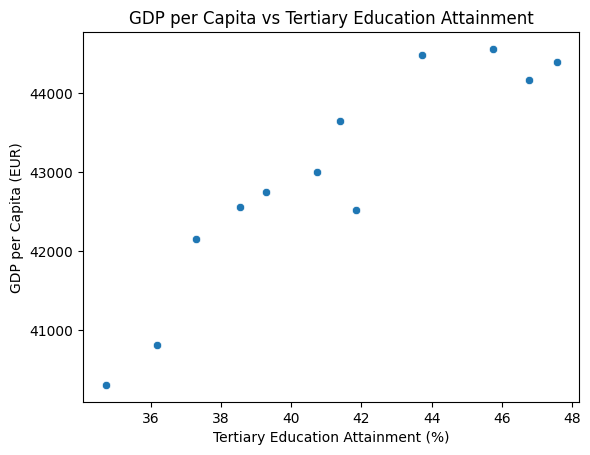

In [150]:
sns.scatterplot(data=aggregate_df, x='education_attainment', y='gdp_per_capita')
plt.title("GDP per Capita vs Tertiary Education Attainment")
plt.xlabel("Tertiary Education Attainment (%)")
plt.ylabel("GDP per Capita (EUR)")
plt.show()

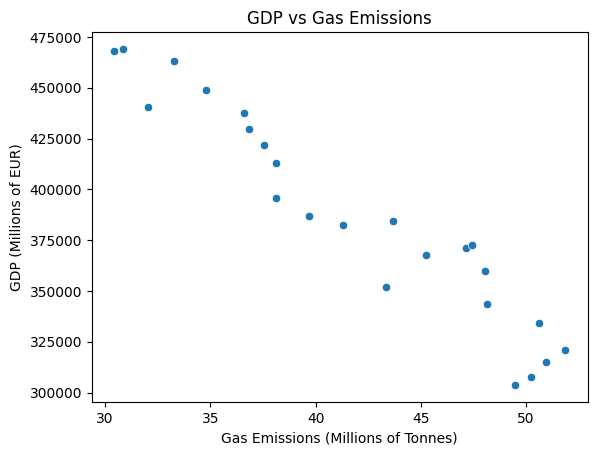

In [151]:
sns.scatterplot(data=aggregate_df, x='gas_emissions', y='gdp')
plt.title("GDP vs Gas Emissions")
plt.xlabel("Gas Emissions (Millions of Tonnes)")
plt.ylabel("GDP (Millions of EUR)")
plt.show()

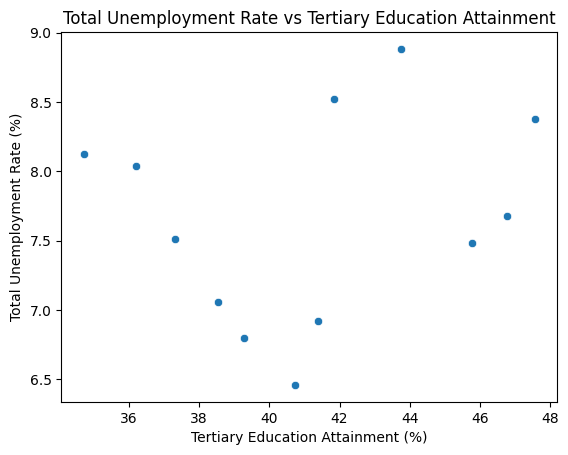

In [152]:
sns.scatterplot(data=aggregate_df, x='education_attainment', y='total_unemployment_rate')
plt.title("Total Unemployment Rate vs Tertiary Education Attainment")
plt.xlabel("Tertiary Education Attainment (%)")
plt.ylabel("Total Unemployment Rate (%)")
plt.show()

#### Correlations

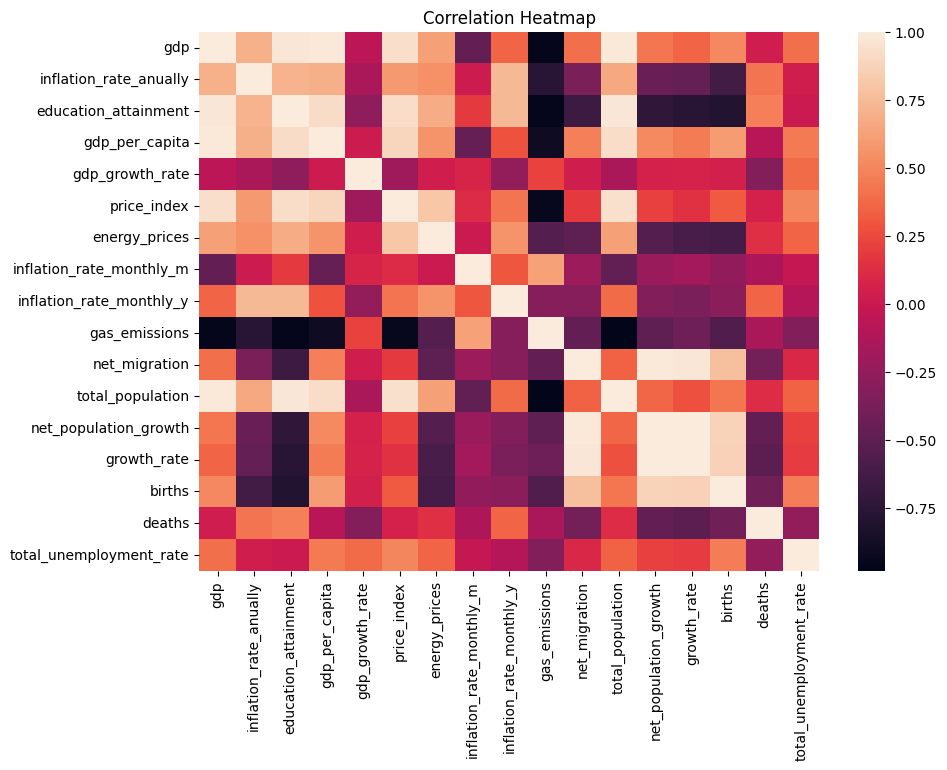

In [153]:
num_df = df.select_dtypes(include='number')
num_df = num_df.drop(columns=[
    'gdp_quarterly', 
    'adult_unemployment_rate', 
    'youth_unemployment_rate',
    'household_income_q1',
    'household_income_q2',
    'household_income_q3',
])
corr_data = num_df.corr()

plt.figure(figsize=(10, 7))
sns.heatmap(data=corr_data, annot=False)
plt.title("Correlation Heatmap")
plt.show()

In [154]:
corr_pairs = (
    corr_data.unstack()
    .sort_values(ascending=False) # type: ignore
    .drop_duplicates()
)
high_corr = corr_pairs[(corr_pairs > 0.9) & (corr_pairs < 1)]
print(high_corr)

growth_rate           net_population_growth    0.995026
net_migration         net_population_growth    0.984034
gdp                   total_population         0.981260
gdp_per_capita        gdp                      0.980233
net_migration         growth_rate              0.975849
education_attainment  gdp                      0.974503
total_population      education_attainment     0.974494
                      price_index              0.944813
price_index           gdp                      0.938076
total_population      gdp_per_capita           0.925199
education_attainment  price_index              0.925074
                      gdp_per_capita           0.922315
dtype: float64


#### Variance Inflation Factor (VIF)

Data is very correlated, thus multiple columns need to be dropped.

'total_population' - strong positve correlation with - gdp, gdp_per_capita

'gas_emissions' - strong negative correlation with - almost all features

'energy_prices' - weak positive correlation with - 'household_income'

'education_attainment' - strong positive correlation with - 'gdp', 'total_population'

In [155]:
clean_df = pd.DataFrame()
subset = aggregate_df[[
    'gdp', 'gdp_growth_rate', 
    'inflation_rate', 'total_unemployment_rate',
    'energy_prices', 'household_income',
]]

clean_df = subset.dropna()
clean_df = add_constant(clean_df)

vif_df = pd.DataFrame()
vif_df['features'] = clean_df.columns # pyright: ignore[reportAttributeAccessIssue]
vif_df['VIF'] = [variance_inflation_factor(clean_df.values, i) for i in range(clean_df.shape[1])] # pyright: ignore[reportAttributeAccessIssue]

vif_df.sort_values(by="VIF", ascending=False)

,features,VIF
0,const,204.658130
1,gdp,4.791978
5,energy_prices,4.506812
6,household_income,4.435157
3,inflation_rate,2.594600
4,total_unemployment_rate,1.644162
2,gdp_growth_rate,1.331788
